In [1]:
# Setup
from __future__ import division
import matplotlib
import numpy as np
import scipy as sp
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import os
import progressbar
import sys

In [2]:
# Start an inference server

from venture.shortcuts import *
v = make_church_prime_ripl()

In [3]:
# Specify linear regression with clustered noise (i.e. not quite CLT noise)

def create_clustered_intercept_model(crp_alpha=0.3,
                                     offset_prior='(uniform_continuous -20 50)',
                                     reg_coef_prior='(uniform_continuous -10 10)',
                                     noise_sd_prior='(uniform_continuous 0.1 10)'):
    v.clear()

    v.assume("cluster_membership_crp", "(make_crp %f)" % crp_alpha)
    v.assume("cluster_membership", "(mem (lambda (index) (cluster_membership_crp)))")

    v.assume("intercept", "(mem (lambda (cluster_index) %s))" % offset_prior)
    v.assume("reg_coef", reg_coef_prior)
    v.assume("noise_sd", noise_sd_prior)

    v.assume("f", "(lambda (x index) (+ (intercept (cluster_membership index)) (* reg_coef x)))")

In [4]:
# Function to read CSV data

def load_data(filename='no_HC.csv'):
    mydata = pd.read_csv(os.path.join('..', 'data', filename), header=0) #python starts counting at zero
    X = mydata['mynewdata.FAI']
    Y = mydata['mynewdata.AQ']
    return X, Y

# Function to observe data

def observe_data(X, Y):
    for index, (x, y) in enumerate(zip(X, Y)):
        v.observe("(normal (f %f %d) noise_sd)" % (x, index), y)

In [5]:
# A function to do inference

def run_inference(n_data_points, n_samples=10, n_skip=10, n_burn=10):
    # Setup lists
    reg_coef_samples = []
    cluster_memberships_samples = []
    cluster_number_samples = []
    # Sample the cluster memberships...
    sample_clusters_string = '(list ' + ' '.join('(cluster_membership %d)' % index
                                                 for index in range(len(X))) + ')'
    # ... and the regression coefficient
    sampling_string = '(list reg_coef %s)' % sample_clusters_string
    # Burn
    for sample_i in range(n_burn):
        v.infer(n_skip)
        print(sample_i)
    # Sample
    for sample_i in range(n_samples):
        v.infer(n_skip)
        # Sample
        data = v.sample(sampling_string)
        reg_coef = data[0]
        cluster_memberships = data[1]
        # Make cluster memberships canonical
        cluster_numbers = np.unique(cluster_memberships)
        canonical_cluster_memberships = np.zeros(len(cluster_memberships))
        for i, value in enumerate(cluster_numbers):
            canonical_cluster_memberships[cluster_memberships==value] = i
        cluster_memberships = canonical_cluster_memberships
        # Count clusters
        cluster_number = len(cluster_numbers)
        # Save to lists
        reg_coef_samples.append(reg_coef)
        cluster_memberships_samples.append(cluster_memberships)
        cluster_number_samples.append(cluster_number)
        # Progress update
        print(sample_i)
    # Return
    return dict(reg_coef_samples=reg_coef_samples,
                cluster_memberships_samples=cluster_memberships_samples,
                cluster_number_samples=cluster_number_samples)

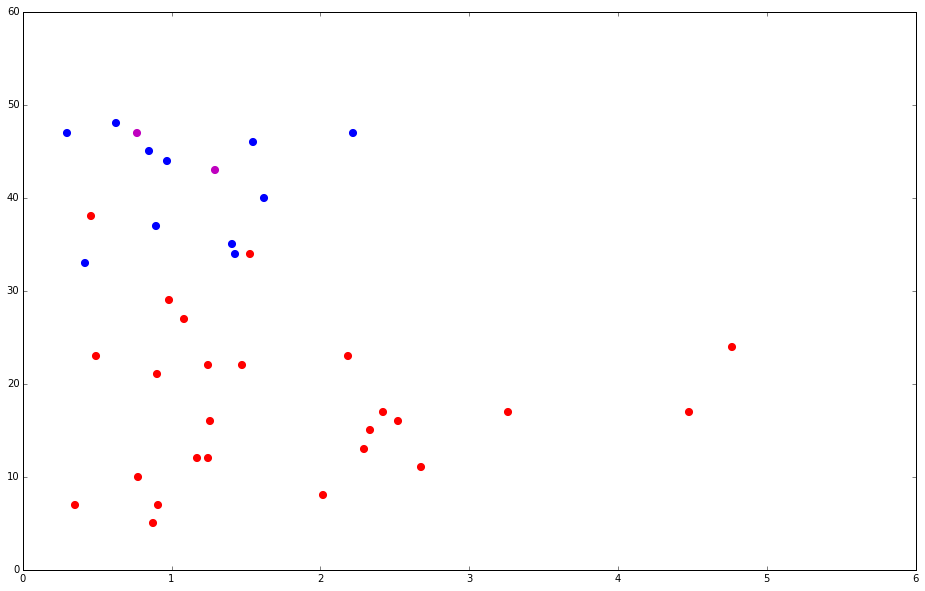

In [6]:
# Just to test - this should draw a picture

# Create default model, load default data and observe

create_clustered_intercept_model()
X, Y = load_data()
observe_data(X, Y)

# Sample the parameters and draw a picture

v.infer(1000)

fig, ax = plt.subplots(figsize=(16, 10))
plt.clf()

cluster_memberships = v.sample('(list ' + ' '.join('(cluster_membership %d)' % index
                                                   for index in range(len(X))) + ')')
cluster_numbers = np.unique(cluster_memberships)
canonical_cluster_memberships = np.zeros(len(cluster_memberships))
for i, value in enumerate(cluster_numbers):
    canonical_cluster_memberships[cluster_memberships==value] = i
cluster_memberships = canonical_cluster_memberships

for (cluster_index, x, y) in zip(cluster_memberships, X, Y):
    if cluster_index == 0:
        color = 'b'
    elif cluster_index == 1:
        color = 'r'
    elif cluster_index == 2:
        color = 'm'
    elif cluster_index == 3:
        color = 'c'
    else:
        color = 'k'
    plt.scatter(x, y, color=color, s=50)

In [7]:
# Define some analysis functions

def HDI_from_MCMC(posterior_samples, credible_mass):
    """
    Computes highest density interval from a sample of representative values,
    estimated as the shortest credible interval
    Takes Arguments posterior_samples (samples from posterior) and credible mass (normally .95)
    """
    sorted_points = sorted(posterior_samples)
    ciIdxInc = np.ceil(credible_mass * len(sorted_points)).astype('int')
    nCIs = len(sorted_points) - ciIdxInc
    ciWidth = [0]*nCIs
    for i in range(0, nCIs):
        ciWidth[i] = sorted_points[i + ciIdxInc] - sorted_points[i]
    HDImin = sorted_points[ciWidth.index(min(ciWidth))]
    HDImax = sorted_points[ciWidth.index(min(ciWidth))+ciIdxInc]
    return HDImin, HDImax

def ACF_and_ESS(samples, corr='pearson', DEBUG=True):
    ACF = []
    for lag in range(1,int(np.floor(len(samples)/2))):
        result = []
        for row in range(lag,len(samples)): # Can't be more than the number of sample points taken
            result.append(samples[row])
        original = samples[:-lag]
        if corr == 'pearson':
            ACF.append(sp.stats.pearsonr(original,result)[0])
        elif corr == 'spearmanr':
            ACF.append(sp.stats.spearmanr(original,result)[0])
        else:
            raise Exception('Unrecognised correlation coefficient : %s' % corr)

    # Effective sample size
#     last_k =[ n for n,i in enumerate(ACF) if i<0.05 ][0]
    # TODO - more sensible number...
    last_k = min(50, len([_ for _ in ACF if not np.isnan(_)]))
    ACF_k = ACF[0:last_k]
    ESS = len(samples)/(1+(2*sum(ACF_k)))
    return ACF, ESS

def analyse_reg_coef(traces, prior=False):
    # For the regression coefficient, check the inference and summarise the posterior
    
    if prior:
        suffix = 'prior'
    else:
        suffix = 'posterior'    

    # Plot traces

    fig, ax = plt.subplots(figsize=(16, 10))
    plt.clf()

    for trace in traces:
        plt.plot(trace['reg_coef_samples'])

    plt.savefig(os.path.join('..', 'plots', 'reg_coef_traces_%s.pdf' % suffix))

    plt.show()

    # Estimate effective sample size

    total_ESS = 0

    fig = plt.figure(figsize=(16, 10))
    plt.clf()

    for i, trace in enumerate(traces):
        ACF, ESS = ACF_and_ESS(trace['reg_coef_samples'])
        total_ESS += ESS
        ax = fig.add_subplot(100 + 10 * len(traces) + (i + 1))
        ax.bar(left=range(len(ACF)), height=ACF)

    plt.savefig(os.path.join('..', 'plots', 'reg_coef_ACFs_%s.pdf' % suffix))

    plt.show()

    print('Total effective sample size = %d' % int(np.floor(total_ESS)))

    # Summarise posterior

    # With a histogram

    fig = plt.figure(figsize=(16, 10))
    plt.clf()

    combined_trace = []
    for trace in traces:
        combined_trace += trace['reg_coef_samples']

    plt.hist(combined_trace, bins=50)

    plt.savefig(os.path.join('..', 'plots', 'reg_coef_hist_%s.pdf' % suffix))

    plt.show()

    # And posterior mass above zero

    p_positive = len([coef for coef in combined_trace if coef > 0]) / len(combined_trace)
    print('Posterior probability of reg coef > 0 = %f' % p_positive)

    # And HDI

    for width in [0.95, 0.9, 0.8, 0.7, 0.5, 0.25]:
        HDI = HDI_from_MCMC(combined_trace, width)
        print('%02.0f%% highest density credible interval = [%f, %f]' % (width * 100, HDI[0], HDI[1]))
        
        
def reg_coef_sensitivity(traces, prior=False):
    if prior:
        suffix = 'prior'
    else:
        suffix = 'posterior'  
        
    # Show many histograms

    fig = plt.figure(figsize=(16, 10))
    plt.clf()

    axes = []

    for i, trace in enumerate(traces):
        if len(axes) == 0:
            axes.append(fig.add_subplot(10 + 100 * len(traces) + (i + 1)))
        else:
            axes.append(fig.add_subplot(10 + 100 * len(traces) + (i + 1), sharex=axes[0], sharey=axes[0]))
        axes[-1].hist(trace['reg_coef_samples'])

    plt.savefig(os.path.join('..', 'plots', 'reg_coef_hist_sensitivity_%s.pdf' % suffix))

    plt.show()
    
def analyse_clusters(traces, prior=False):
    # TODO Instead of using histogram, use bar chart after calling np.bincount - more flexible for graphic making
    # counts = np.bincount(samples) 

    if prior:
        suffix = 'prior'
    else:
        suffix = 'posterior'  

    # Plot traces

    fig, ax = plt.subplots(figsize=(16, 10))
    plt.clf()

    for trace in traces:
        plt.plot(trace['cluster_number_samples'])

    plt.savefig(os.path.join('..', 'plots', 'cluster_number_traces_%s.pdf' % suffix))

    plt.show()

    # Estimate effective sample size

    total_ESS = 0

    fig = plt.figure(figsize=(16, 10))
    plt.clf()

    for i, trace in enumerate(traces):
        ACF, ESS = ACF_and_ESS(trace['cluster_number_samples'], corr='spearmanr')
        total_ESS += ESS
        ax = fig.add_subplot(100 + 10 * len(traces) + (i + 1))
        ax.bar(left=range(len(ACF)), height=ACF)

    plt.savefig(os.path.join('..', 'plots', 'cluster_number_ACFs_%s.pdf' % suffix))

    plt.show()

    print('Total effective sample size = %d' % int(np.floor(total_ESS)))

    # Summarise posterior

    # With a histogram

    fig = plt.figure(figsize=(16, 10))
    plt.clf()

    combined_trace = []
    for trace in traces:
        combined_trace += trace['cluster_number_samples']

    plt.hist(combined_trace, bins=50)

    plt.savefig(os.path.join('..', 'plots', 'cluster_number_hist_%s.pdf' % suffix))

    plt.show()

    # And posterior mass above zero

    p_more_than_one_cluster = len([number for number in combined_trace if number > 1]) / len(combined_trace)
    print('Posterior probability of cluster number > 1 = %f' % p_more_than_one_cluster)

    # And HDI

    for width in [0.95, 0.9, 0.8, 0.7, 0.5, 0.25]:
        HDI = HDI_from_MCMC(combined_trace, width)
        print('%02.0f%% highest density credible interval = [%f, %f]' % (width * 100, HDI[0], HDI[1]))

    # Now clustering

    combined_trace = []
    for trace in traces:
        combined_trace += trace['cluster_memberships_samples']

    cluster_assignments = np.array(combined_trace)

    cluster_labels = np.unique(cluster_assignments)

    co_occurrence_matrix = np.zeros((cluster_assignments.shape[1], cluster_assignments.shape[1]))

    for label in cluster_labels:
        co_occurrence_matrix += np.dot((cluster_assignments.T == label) * 1, (cluster_assignments == label) * 1)


    # Reshape co-occurence_matrix by linkage
    reshaped = sch.linkage(co_occurrence_matrix)

    # print(co_occurrence_matrix)
    # print(co_occurrence_matrix.shape)

    # plt.clf()
    # fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

    # ax.imshow(co_occurrence_matrix, interpolation='nearest') #interpolation changes fuzzyness. try 'none' or 'nearest'
    # plt.show()

    co_occurrence_matrix = np.divide(co_occurrence_matrix, 10)

    # Reshape co-occurence_matrix by linkage
    linkage = sch.linkage(co_occurrence_matrix)
    dendrogram_right = sch.dendrogram(linkage, orientation='right')
    dendrogram = sch.dendrogram(linkage)
    idx1 = dendrogram_right['leaves']
    idx2 = dendrogram['leaves']
    co_occurrence_matrix = co_occurrence_matrix[idx1,:]
    co_occurrence_matrix = co_occurrence_matrix[:,idx2]

    # Co-occurrence matrix figure

    # plt.clf()
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
    map=ax.imshow(co_occurrence_matrix, interpolation='nearest')
    plt.colorbar(map)
    plt.savefig(os.path.join('..', 'plots', 'co-occurrence_%s.pdf' % suffix)) # this line has to come before plt.show
    plt.show()

    # print(reshaped)
    # reshaped.shape

    # plt.clf()
    # fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
    # ax.imshow(reshaped, interpolation='nearest') 
    # plt.savefig('co-occurrence.pdf') # this line has to come before plt.show
    # plt.show()
    
def cluster_sensitivity(traces, prior=False):
    if prior:
        suffix = 'prior'
    else:
        suffix = 'posterior'  
        
    # Show many histograms

    fig = plt.figure(figsize=(16, 10))
    plt.clf()

    axes = []

    for i, trace in enumerate(traces):
        if len(axes) == 0:
            axes.append(fig.add_subplot(10 + 100 * len(traces) + (i + 1)))
        else:
            axes.append(fig.add_subplot(10 + 100 * len(traces) + (i + 1), sharex=axes[0], sharey=axes[0]))
        axes[-1].hist(trace['cluster_number_samples'])

    plt.savefig(os.path.join('..', 'plots', 'cluster_number_hist_sensitivity_%s.pdf' % suffix))

    plt.show()

In [8]:
# Run inference with the standard model
# Set experiment parameters

DEBUG = True
if DEBUG:
    n_traces = 3
    n_samples = 100
    n_skip = 25
    n_burn = 10
else:
    n_traces = 5
    n_samples = 1000
    n_skip = 1000
    n_burn = 1000

# Load data

X, Y = load_data()

# Run inference several times - WITHOUT DATA - i.e. looking at the prior

traces = []
for _ in range(n_traces):
    # Create model
    create_clustered_intercept_model()
    # Observe data
#     observe_data(X, Y)
    # Collect trace
    traces.append(run_inference(n_data_points=len(Y), n_samples=n_samples, n_skip=n_skip, n_burn=n_burn))

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


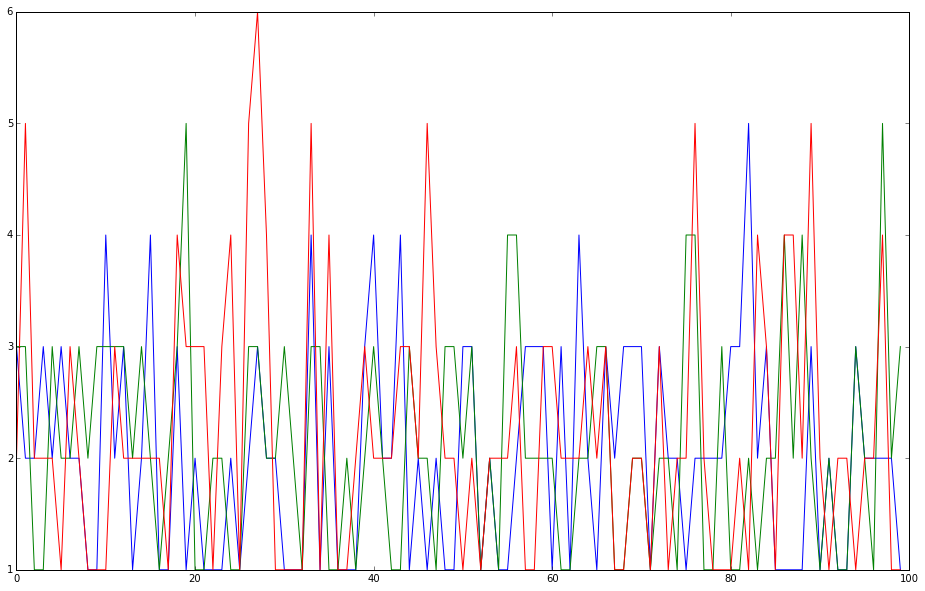

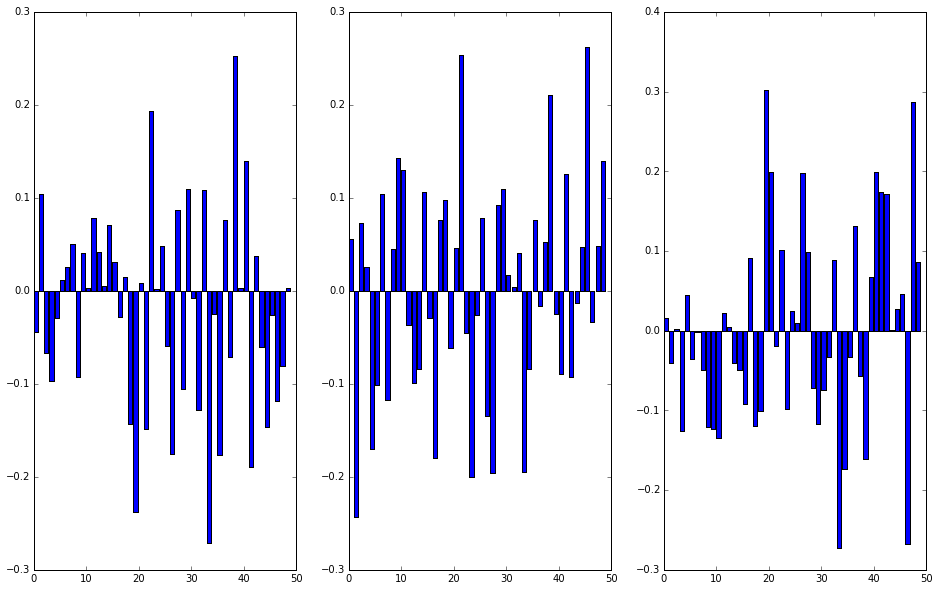

Total effective sample size = 73


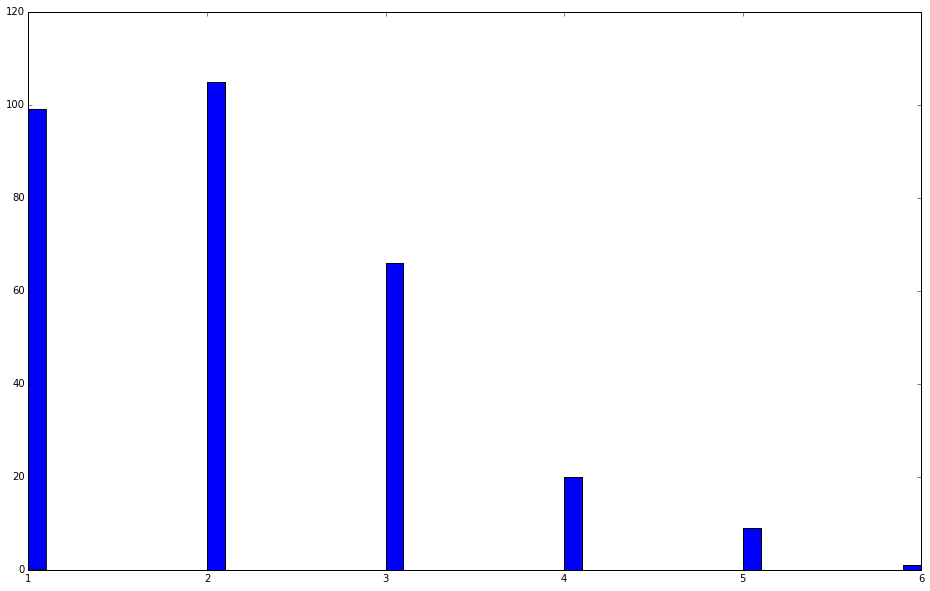

Posterior probability of cluster number > 1 = 0.670000
95% highest density credible interval = [1.000000, 4.000000]
90% highest density credible interval = [1.000000, 4.000000]
80% highest density credible interval = [1.000000, 3.000000]
70% highest density credible interval = [1.000000, 3.000000]
50% highest density credible interval = [1.000000, 2.000000]
25% highest density credible interval = [1.000000, 1.000000]


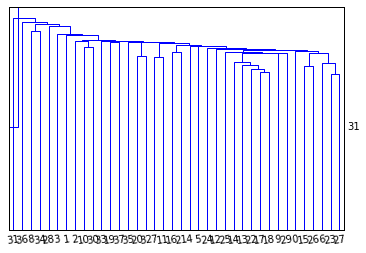

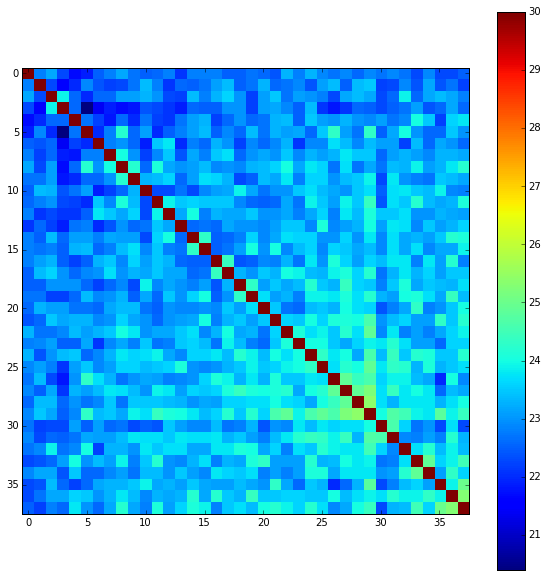

In [9]:
# Summarise the prior - clusters

analyse_clusters(traces=traces, prior=True)

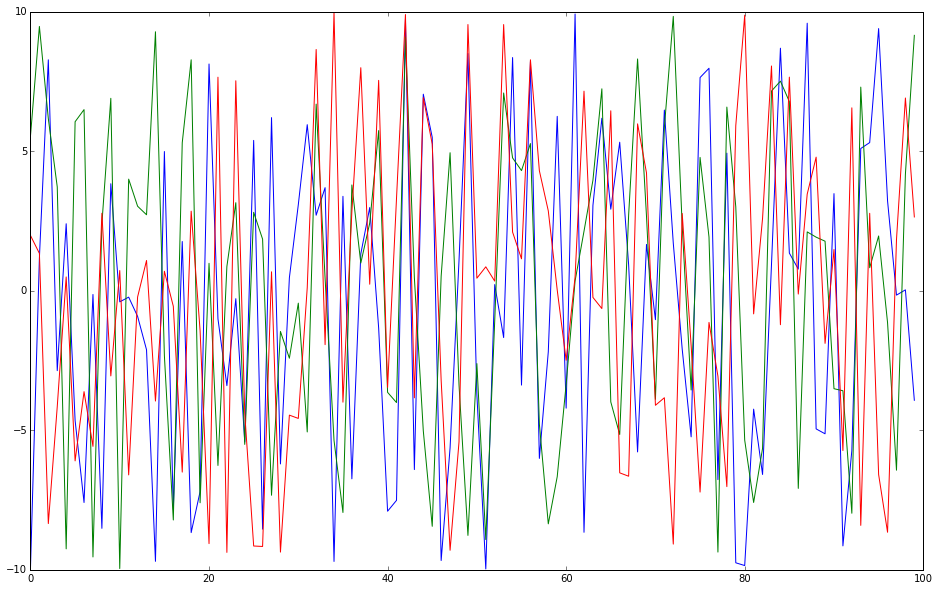

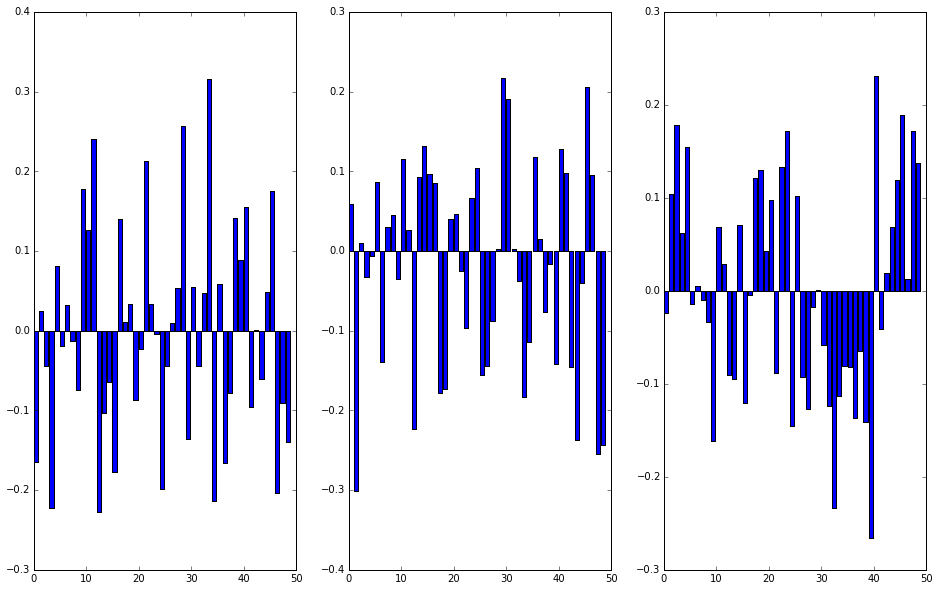

Total effective sample size = 140


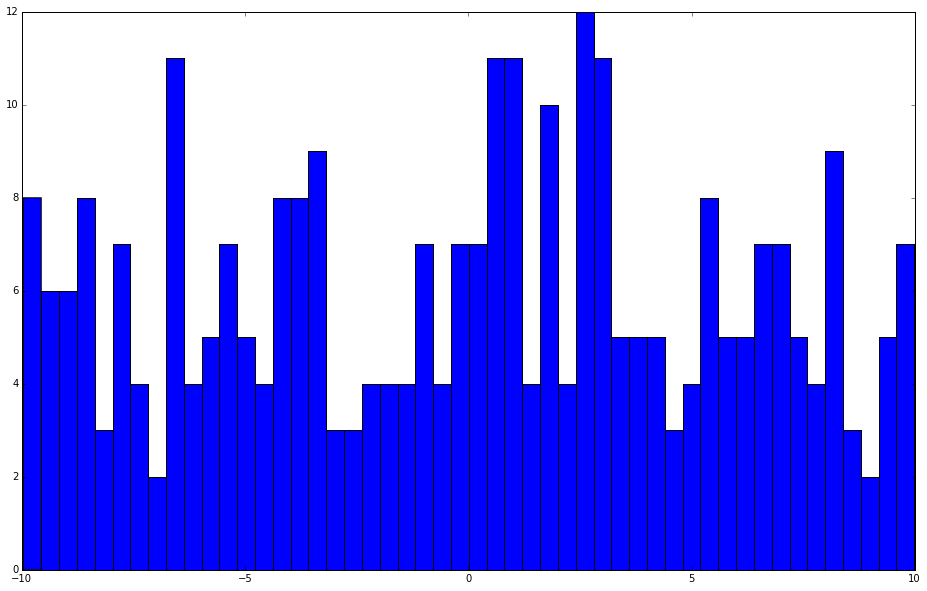

Posterior probability of reg coef > 0 = 0.530000
95% highest density credible interval = [-9.969966, 8.695328]
90% highest density credible interval = [-9.954708, 7.658337]
80% highest density credible interval = [-6.767932, 8.650064]
70% highest density credible interval = [-9.969966, 3.158207]
50% highest density credible interval = [-0.442491, 8.360822]
25% highest density credible interval = [-0.282686, 3.085409]


In [10]:
# Summarise the prior - regression coefficient

analyse_reg_coef(traces=traces, prior=True)

In [11]:
# Now run inference several times with data

traces = []
for _ in range(n_traces):
    # Create model
    create_clustered_intercept_model()
    # Observe data
    observe_data(X, Y)
    # Collect trace
    traces.append(run_inference(n_data_points=len(Y), n_samples=n_samples, n_skip=n_skip, n_burn=n_burn))

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


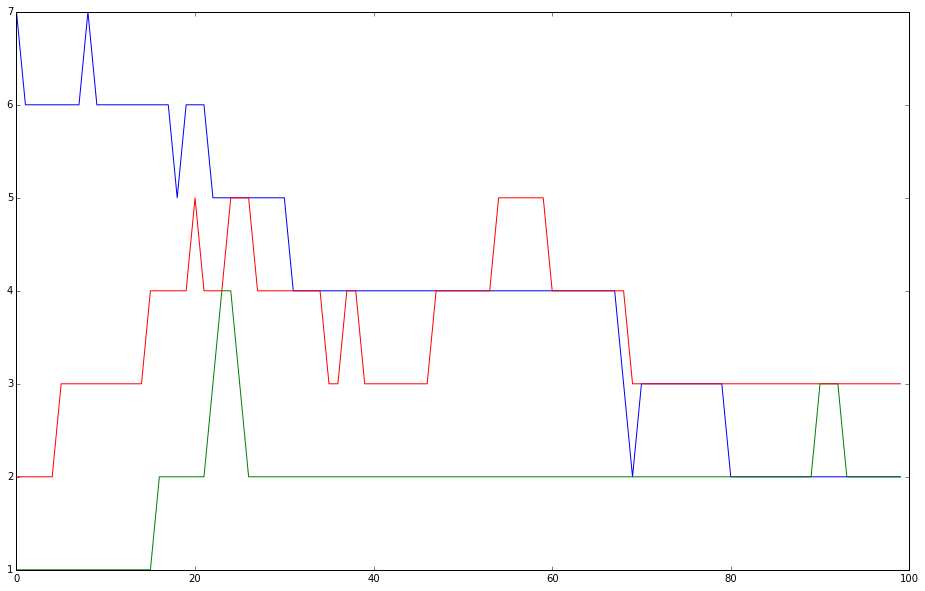

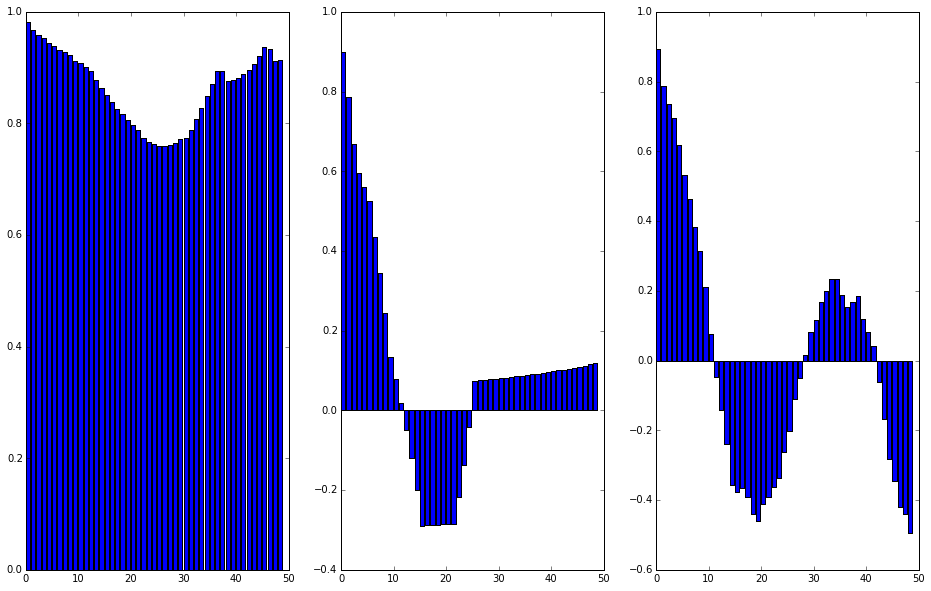

Total effective sample size = 58


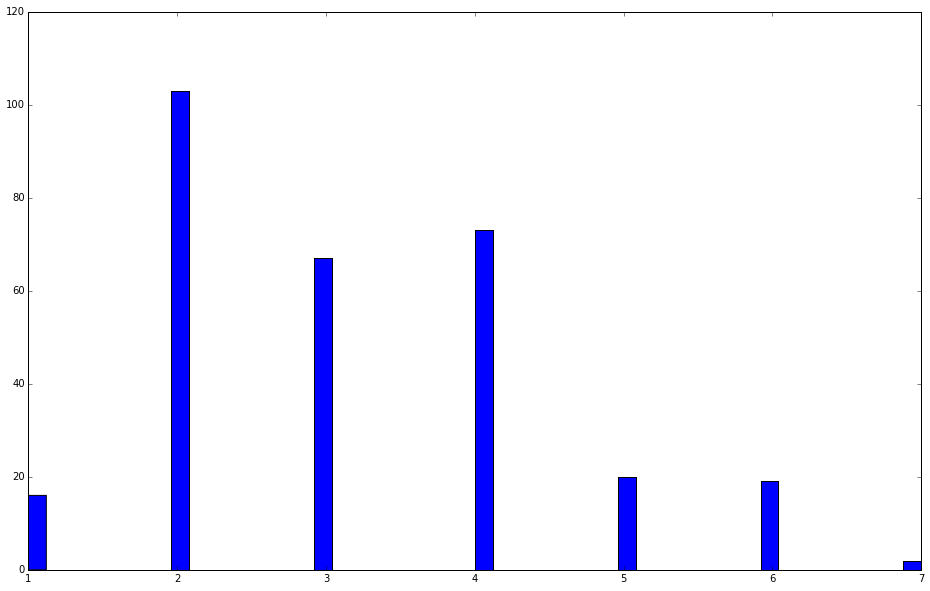

Posterior probability of cluster number > 1 = 0.946667
95% highest density credible interval = [1.000000, 6.000000]
90% highest density credible interval = [1.000000, 5.000000]
80% highest density credible interval = [2.000000, 4.000000]
70% highest density credible interval = [2.000000, 4.000000]
50% highest density credible interval = [2.000000, 3.000000]
25% highest density credible interval = [2.000000, 2.000000]


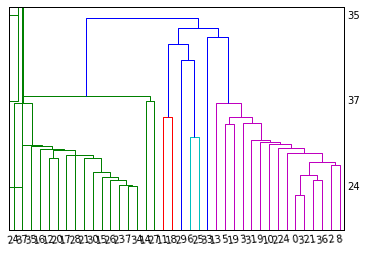

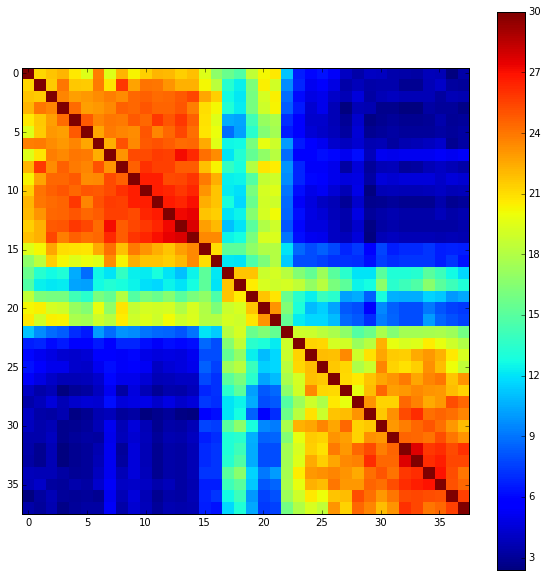

In [12]:
# Summarise the posterior - clusters

analyse_clusters(traces=traces, prior=False)

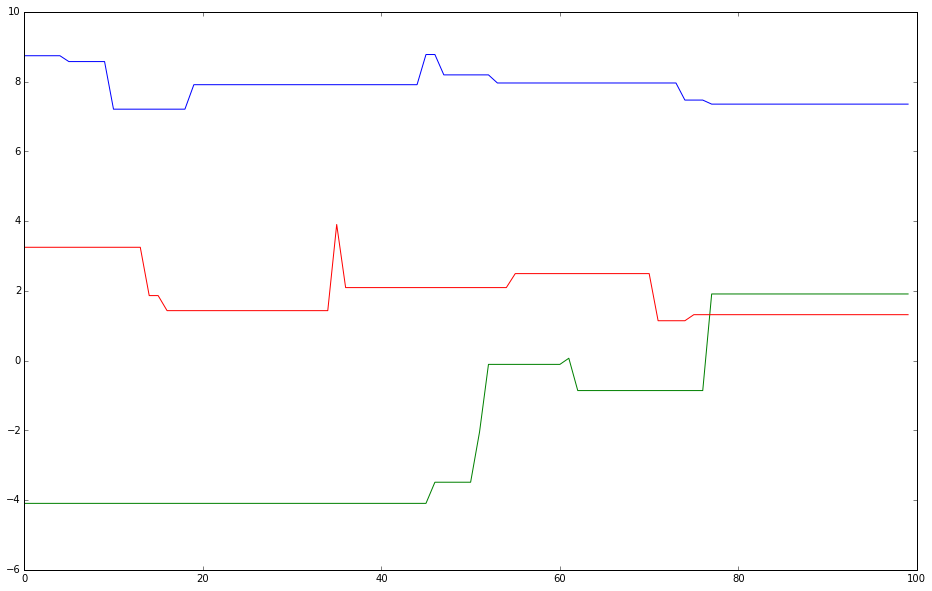

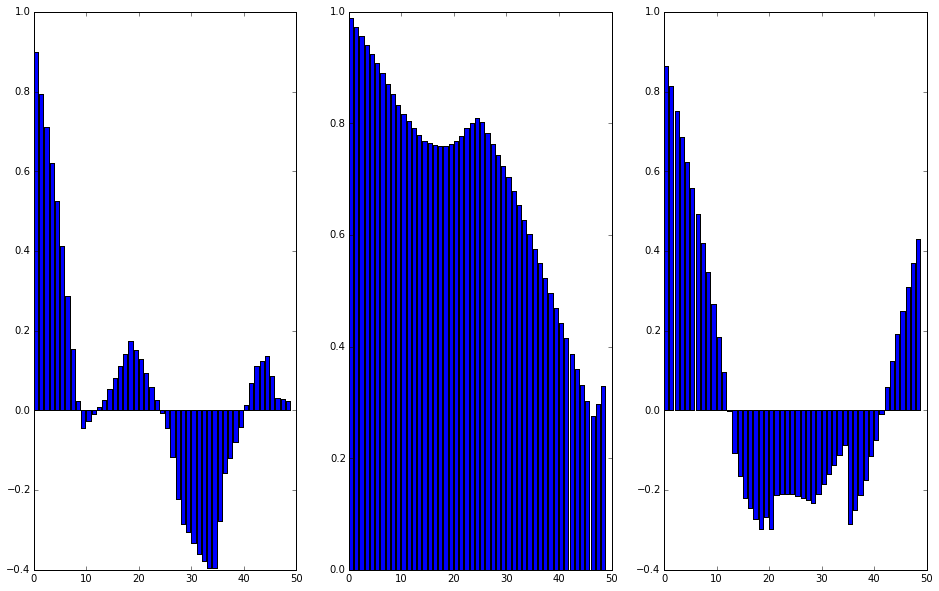

Total effective sample size = 36


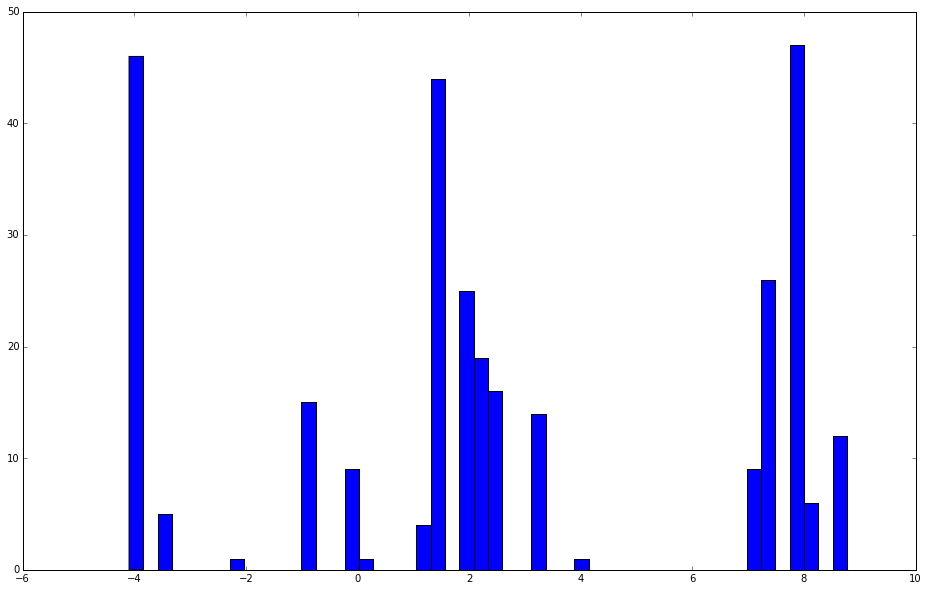

Posterior probability of reg coef > 0 = 0.746667
95% highest density credible interval = [-4.095092, 8.191132]
90% highest density credible interval = [-4.095092, 7.958927]
80% highest density credible interval = [-0.860773, 8.572620]
70% highest density credible interval = [1.141652, 8.191132]
50% highest density credible interval = [1.315280, 7.352776]
25% highest density credible interval = [7.207921, 7.958927]


In [13]:
# Summarise the posterior - regression coefficient

analyse_reg_coef(traces=traces, prior=False)

In [14]:
# Sensitivity analysis - CRP alpha - lower alpha means fewer clusters

# Set experiment parameters
if DEBUG:
    alphas = [0.033, 0.1, 0.3, 0.9, 2.7]
else:
    alphas = [0.033, 0.1, 0.3, 0.9, 2.7, 8.1]

# Load data

X, Y = load_data()

In [15]:
# Run inference several times without data

traces = []
for alpha in alphas:
    # Create model
    create_clustered_intercept_model(crp_alpha=alpha)
    # Observe data
#     observe_data(X, Y)
    # Collect trace
    traces.append(run_inference(n_data_points=len(Y), n_samples=n_samples, n_skip=n_skip, n_burn=n_burn))

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


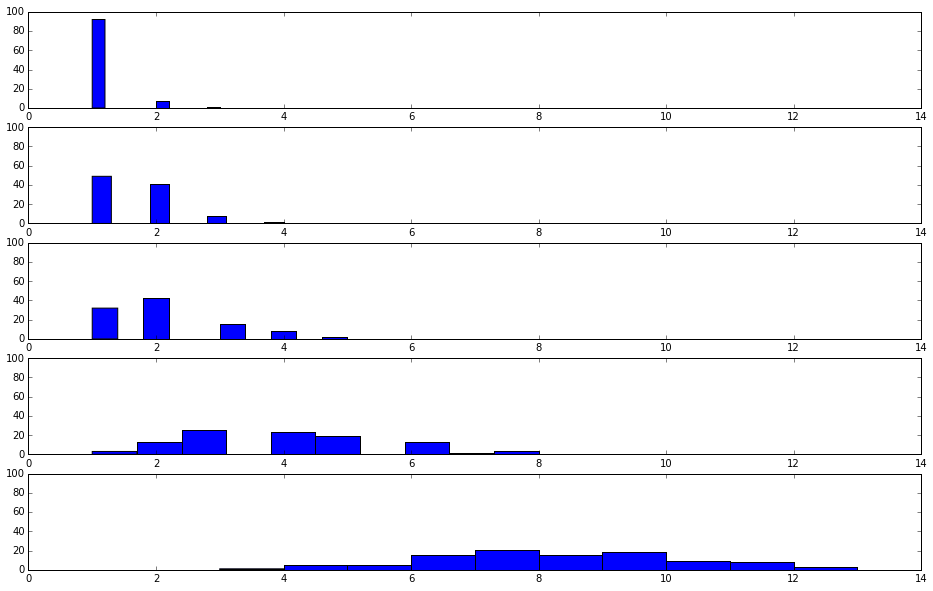

In [16]:
cluster_sensitivity(traces=traces, prior=True)

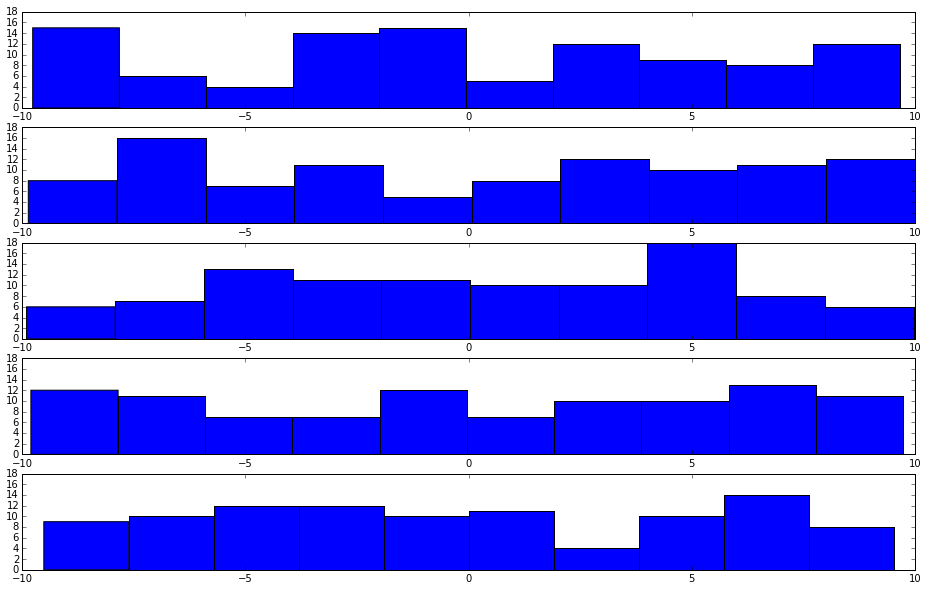

In [17]:
reg_coef_sensitivity(traces=traces, prior=True)

In [18]:
# Run inference several times with data

traces = []
for alpha in alphas:
    # Create model
    create_clustered_intercept_model(crp_alpha=alpha)
    # Observe data
    observe_data(X, Y)
    # Collect trace
    traces.append(run_inference(n_data_points=len(Y), n_samples=n_samples, n_skip=n_skip, n_burn=n_burn))

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


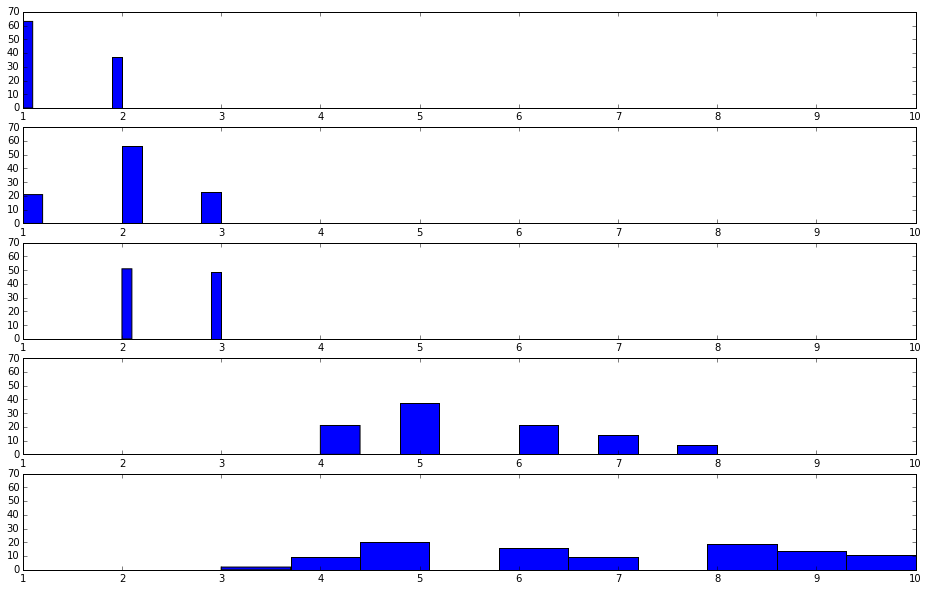

In [19]:
cluster_sensitivity(traces=traces, prior=False)

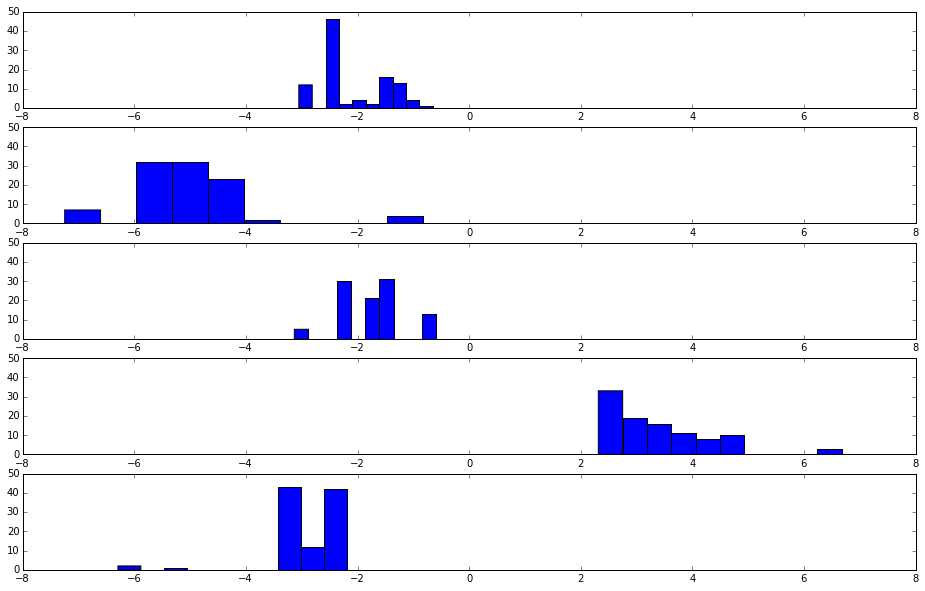

In [20]:
reg_coef_sensitivity(traces=traces, prior=False)